# Solución Desafío 3 - Modelo de Lenguaje con Tokenización por Caracteres
## RNNs para Generación de Texto

### Objetivo
Entrenar un modelo de lenguaje basado en arquitecturas de redes neuronales recurrentes usando tokenización a nivel de caracteres. Se explorarán diferentes arquitecturas (SimpleRNN, LSTM, GRU) y estrategias de generación de secuencias (greedy search, beam search determinístico y estocástico).

## 1. Setup e Importaciones

In [1]:
import random
import io
import pickle
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.special import softmax

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import (
    Dense, LSTM, GRU, SimpleRNN, 
    Embedding, Dropout, Input, 
    TimeDistributed, CategoryEncoding
)
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import pad_sequences

warnings.filterwarnings('ignore')

# Configuración de visualización
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')

print("Librerías cargadas correctamente")
print(f"TensorFlow/Keras version: {keras.__version__}")

2025-12-08 10:56:59.864306: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-08 10:56:59.872186: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-08 10:57:00.217786: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-08 10:57:01.488258: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

Librerías cargadas correctamente
TensorFlow/Keras version: 3.12.0


## 2. Selección y Carga del Corpus

Para este desafío utilizaremos **"Don Quijote de la Mancha"** de Miguel de Cervantes, uno de los textos más importantes de la literatura española. Este corpus es ideal porque:

- **Riqueza lingüística**: Español clásico con vocabulario extenso y variado
- **Estructura narrativa compleja**: Diálogos, descripciones, reflexiones
- **Longitud adecuada**: Suficiente texto para entrenar un modelo robusto
- **Dominio público**: Fácilmente accesible

Descargaremos el texto desde el Proyecto Gutenberg.

In [2]:
# Descargar Don Quijote desde Proyecto Gutenberg
import urllib.request
import bs4 as bs

try:
    # Intentar desde Gutenberg (español)
    print("Descargando 'Don Quijote de la Mancha' desde Proyecto Gutenberg...")
    url = 'https://www.gutenberg.org/files/2000/2000-0.txt'
    response = urllib.request.urlopen(url)
    raw_text = response.read().decode('utf-8')
    print("✓ Descarga exitosa desde Gutenberg")
except:
    # Alternativa: La vuelta al mundo en 80 días
    print("Usando texto alternativo: La vuelta al mundo en 80 días...")
    raw_html = urllib.request.urlopen('https://www.textos.info/julio-verne/la-vuelta-al-mundo-en-80-dias/ebook')
    raw_html = raw_html.read()
    article_html = bs.BeautifulSoup(raw_html, 'lxml')
    article_paragraphs = article_html.find_all('p')
    raw_text = ''
    for para in article_paragraphs:
        raw_text += para.text + ' '
    print("✓ Descarga exitosa (texto alternativo)")

print(f"\nLongitud del texto descargado: {len(raw_text):,} caracteres")

Descargando 'Don Quijote de la Mancha' desde Proyecto Gutenberg...
✓ Descarga exitosa desde Gutenberg

Longitud del texto descargado: 2,168,460 caracteres


## 3. Preprocesamiento del Texto

In [3]:
# Limpieza básica del texto
# Eliminar encabezados del Proyecto Gutenberg (si están presentes)
start_markers = ['*** START OF', 'CAPÍTULO I', 'Capítulo I', 'PRIMERA PARTE']
end_markers = ['*** END OF', 'FIN']

# Intentar encontrar inicio del texto real
start_idx = 0
for marker in start_markers:
    idx = raw_text.find(marker)
    if idx != -1:
        # Buscar el primer salto de línea después del marcador
        start_idx = raw_text.find('\n', idx) + 1
        break

# Intentar encontrar final del texto real
end_idx = len(raw_text)
for marker in end_markers:
    idx = raw_text.rfind(marker)
    if idx != -1:
        end_idx = idx
        break

# Extraer texto limpio
article_text = raw_text[start_idx:end_idx]

# Convertir a minúsculas
article_text = article_text.lower()

# Limpiar espacios múltiples y saltos de línea excesivos
import re
article_text = re.sub(r'\n+', '\n', article_text)
article_text = re.sub(r' +', ' ', article_text)

print(f"Longitud del texto procesado: {len(article_text):,} caracteres")
print(f"\nPrimeros 500 caracteres del corpus:\n")
print(article_text[:500])
print(f"\n...\n")
print(f"Últimos 300 caracteres del corpus:\n")
print(article_text[-300:])

Longitud del texto procesado: 2,148,403 caracteres

Primeros 500 caracteres del corpus:





el ingenioso hidalgo don quijote de la mancha



por miguel de cervantes saavedra





el ingenioso hidalgo don quijote de la mancha


 
tasa

 
testimonio de las erratas

 
el rey

 
al duque de béjar

 
prólogo

 
al libro de don quijote de la mancha



que trata de la condición y ejercicio del famoso
hidalgo don quijote de la mancha

que trata de la primera salida que de su tierra hizo
el ingenioso don quijote

donde se cuenta la graciosa manera 

...

Últimos 300 caracteres del corpus:

itos enteramente, como deseaba, pues no ha sido otro mi deseo que
poner en aborrecimiento de los hombres las fingidas y disparatadas
historias de los libros de caballerías, que, por las de mi verdadero don
quijote, van ya tropezando, y han de caer del todo, sin duda alguna. vale.

fin







## 4. Análisis del Vocabulario de Caracteres

In [4]:
# Construir vocabulario de caracteres
chars_vocab = sorted(set(article_text))
vocab_size = len(chars_vocab)

print(f"Tamaño del vocabulario: {vocab_size} caracteres únicos")
print(f"\nCaracteres en el vocabulario:")
print(chars_vocab)

# Análisis de frecuencias
from collections import Counter
char_freq = Counter(article_text)
most_common = char_freq.most_common(20)

print(f"\nTop 20 caracteres más frecuentes:")
for char, count in most_common:
    char_display = char if char not in ['\n', '\t', ' '] else repr(char)
    print(f"  '{char_display}': {count:,} veces ({count/len(article_text)*100:.2f}%)")

Tamaño del vocabulario: 63 caracteres únicos

Caracteres en el vocabulario:
['\n', '\r', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', ':', ';', '?', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '¡', '«', '»', '¿', 'à', 'á', 'é', 'í', 'ï', 'ñ', 'ó', 'ù', 'ú', 'ü', '—']

Top 20 caracteres más frecuentes:
  '' '': 354,695 veces (16.51%)
  'e': 223,399 veces (10.40%)
  'a': 194,623 veces (9.06%)
  'o': 154,414 veces (7.19%)
  's': 126,537 veces (5.89%)
  'n': 109,218 veces (5.08%)
  'r': 101,534 veces (4.73%)
  'l': 89,699 veces (4.18%)
  'd': 87,946 veces (4.09%)
  'u': 78,779 veces (3.67%)
  'i': 78,104 veces (3.64%)
  't': 62,248 veces (2.90%)
  'c': 59,916 veces (2.79%)
  'm': 44,838 veces (2.09%)
  ',': 40,277 veces (1.87%)
': 37,679 veces (1.75%)
  ''\n'': 37,679 veces (1.75%)
  'p': 35,601 veces (1.66%)
  'q': 32,709 veces (1.52%)
  'y': 25,213 veces (1.17%)


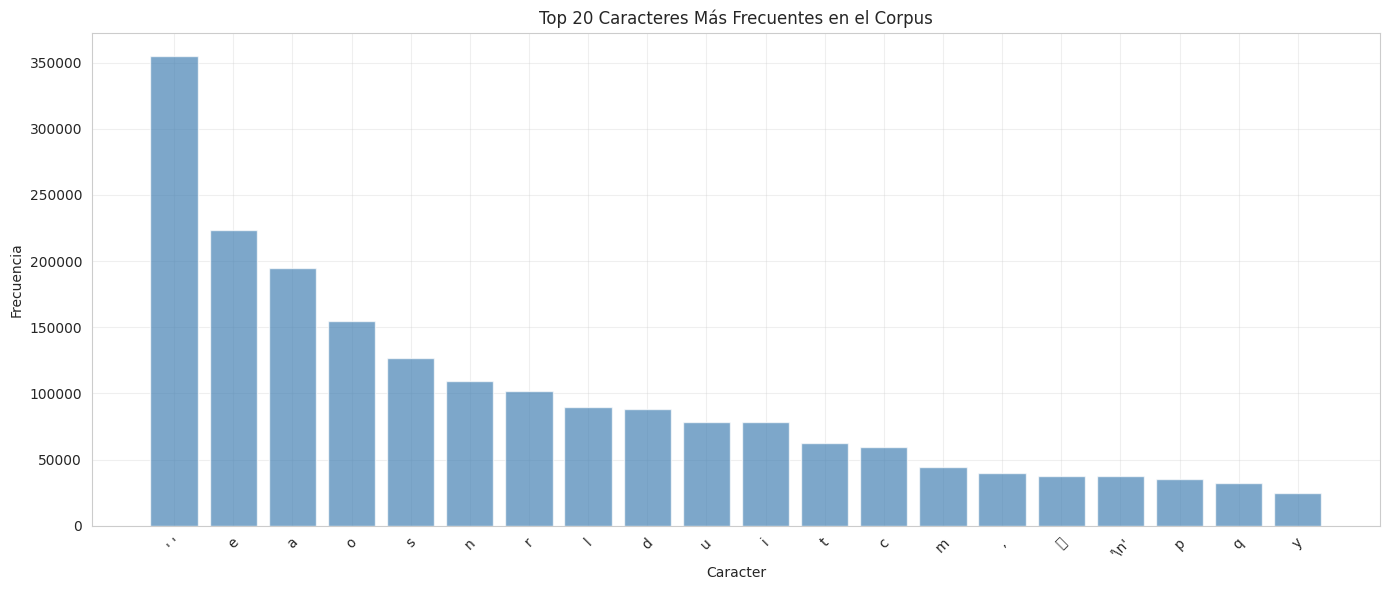

In [5]:
# Visualización de frecuencias
chars_display = [c if c not in ['\n', '\t', ' '] else repr(c) for c, _ in most_common]
counts = [count for _, count in most_common]

plt.figure(figsize=(14, 6))
plt.bar(range(len(chars_display)), counts, color='steelblue', alpha=0.7)
plt.xticks(range(len(chars_display)), chars_display, rotation=45)
plt.xlabel('Caracter')
plt.ylabel('Frecuencia')
plt.title('Top 20 Caracteres Más Frecuentes en el Corpus')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Construcción de Diccionarios de Tokenización

In [6]:
# Construir diccionarios char <-> index
char2idx = {char: idx for idx, char in enumerate(chars_vocab)}
idx2char = {idx: char for idx, char in enumerate(chars_vocab)}

print(f"Diccionario char2idx (primeros 10 elementos):")
for i, (char, idx) in enumerate(list(char2idx.items())[:10]):
    char_display = char if char not in ['\n', '\t', ' '] else repr(char)
    print(f"  '{char_display}' -> {idx}")

print(f"\n...")
print(f"\nTotal de mappings: {len(char2idx)}")

Diccionario char2idx (primeros 10 elementos):
  ''\n'' -> 0
' -> 1
  '' '' -> 2
  '!' -> 3
  '"' -> 4
  ''' -> 5
  '(' -> 6
  ')' -> 7
  ',' -> 8
  '-' -> 9

...

Total de mappings: 63


## 6. Selección del Tamaño de Contexto

Para un modelo de lenguaje basado en caracteres, el tamaño de contexto puede ser más flexible que en modelos basados en palabras. Elegiremos un valor que balance:

- **Contexto suficiente**: Para capturar patrones lingüísticos
- **Eficiencia computacional**: Secuencias no excesivamente largas
- **Memoria del modelo**: RNNs pueden tener problemas con secuencias muy largas

In [7]:
# Seleccionar tamaño de contexto
# Para caracteres, valores típicos: 50-200
max_context_size = 100

print(f"Tamaño de contexto seleccionado: {max_context_size} caracteres")
print(f"\nEsto equivale aproximadamente a:")
print(f"  - {max_context_size / 5:.0f} palabras (asumiendo promedio de 5 caracteres/palabra)")
print(f"  - {max_context_size / 80:.1f} líneas (asumiendo 80 caracteres/línea)")

Tamaño de contexto seleccionado: 100 caracteres

Esto equivale aproximadamente a:
  - 20 palabras (asumiendo promedio de 5 caracteres/palabra)
  - 1.2 líneas (asumiendo 80 caracteres/línea)


## 7. Tokenización del Corpus Completo

In [8]:
# Tokenizar todo el texto
tokenized_text = [char2idx[ch] for ch in article_text]

print(f"Texto tokenizado:")
print(f"  Longitud: {len(tokenized_text):,} tokens")
print(f"\nPrimeros 100 tokens:")
print(tokenized_text[:100])
print(f"\nReconstrucción de los primeros 100 caracteres:")
print(''.join([idx2char[idx] for idx in tokenized_text[:100]]))

Texto tokenizado:
  Longitud: 2,148,403 tokens

Primeros 100 tokens:
[1, 0, 1, 0, 1, 0, 1, 0, 27, 33, 2, 31, 35, 29, 27, 35, 31, 36, 40, 36, 2, 30, 31, 26, 23, 33, 29, 36, 2, 26, 36, 35, 2, 38, 42, 31, 32, 36, 41, 27, 2, 26, 27, 2, 33, 23, 2, 34, 23, 35, 25, 30, 23, 1, 0, 1, 0, 1, 0, 1, 0, 37, 36, 39, 2, 34, 31, 29, 42, 27, 33, 2, 26, 27, 2, 25, 27, 39, 43, 23, 35, 41, 27, 40, 2, 40, 23, 23, 43, 27, 26, 39, 23, 1, 0, 1, 0, 1, 0, 1]

Reconstrucción de los primeros 100 caracteres:




el ingenioso hidalgo don quijote de la mancha



por miguel de cervantes saavedra





## 8. Estructuración del Dataset

Dividiremos el dataset en entrenamiento y validación. Usaremos una estrategia **many-to-many**:

- **Entrada**: Secuencia de tokens [$x_0, x_1, ..., x_N$]
- **Target**: Secuencia de tokens [$x_1, x_2, ..., x_{N+1}$] (desplazada en 1)

Esta estructura permite propagar gradientes en cada paso temporal, mejorando el aprendizaje.

In [9]:
# Separar train/validation
p_val = 0.1  # 10% para validación
num_val = int(np.ceil(len(tokenized_text) * p_val / max_context_size))

# Separar secuencias
train_text = tokenized_text[:-num_val * max_context_size]
val_text = tokenized_text[-num_val * max_context_size:]

print(f"División del dataset:")
print(f"  Entrenamiento: {len(train_text):,} caracteres")
print(f"  Validación: {len(val_text):,} caracteres")
print(f"  Secuencias de validación: {num_val}")

División del dataset:
  Entrenamiento: 1,933,503 caracteres
  Validación: 214,900 caracteres
  Secuencias de validación: 2149


In [10]:
# Crear secuencias de validación
tokenized_sentences_val = [
    val_text[i * max_context_size : (i + 1) * max_context_size] 
    for i in range(num_val)
]

print(f"Secuencias de validación creadas: {len(tokenized_sentences_val)}")
print(f"Longitud de cada secuencia: {len(tokenized_sentences_val[0])}")
print(f"\nEjemplo de secuencia de validación (primeros 50 chars):")
print(''.join([idx2char[idx] for idx in tokenized_sentences_val[0][:50]]))

Secuencias de validación creadas: 2149
Longitud de cada secuencia: 100

Ejemplo de secuencia de validación (primeros 50 chars):
re
una fresca arboleda hallaron, en el margen de 


In [11]:
# Crear secuencias de entrenamiento (many-to-many)
# Cada secuencia de longitud max_context_size predice la siguiente
tokenized_sentences_train = [
    train_text[i : i + max_context_size] 
    for i in range(len(train_text) - max_context_size)
]

print(f"Secuencias de entrenamiento: {len(tokenized_sentences_train):,}")
print(f"\nEjemplo:")
print(f"  Input (X): {tokenized_sentences_train[0][:20]}...")
print(f"  Texto:     '{(''.join([idx2char[idx] for idx in tokenized_sentences_train[0][:20]]))}...'")

Secuencias de entrenamiento: 1,933,403

Ejemplo:
  Input (X): [1, 0, 1, 0, 1, 0, 1, 0, 27, 33, 2, 31, 35, 29, 27, 35, 31, 36, 40, 36]...
  Texto:     '



el ingenioso...'


In [12]:
# Preparar X (input) y y (target)
# X: secuencias de entrada
# y: secuencias desplazadas en 1 (lo que sigue)
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

print(f"Forma de X: {X.shape}")
print(f"Forma de y: {y.shape}")
print(f"\nPrimer ejemplo:")
print(f"  X[0][:20]: {X[0][:20]}")
print(f"  y[0][:20]: {y[0][:20]}")
print(f"\nVerificación: y debe ser X desplazado en 1 posición")
print(f"  X[0][1:10]: {X[0][1:10]}")
print(f"  y[0][:9]:   {y[0][:9]}")
print(f"  ¿Son iguales? {np.array_equal(X[0][1:10], y[0][:9])}")

Forma de X: (1933402, 100)
Forma de y: (1933402, 100)

Primer ejemplo:
  X[0][:20]: [ 1  0  1  0  1  0  1  0 27 33  2 31 35 29 27 35 31 36 40 36]
  y[0][:20]: [ 0  1  0  1  0  1  0 27 33  2 31 35 29 27 35 31 36 40 36  2]

Verificación: y debe ser X desplazado en 1 posición
  X[0][1:10]: [ 0  1  0  1  0  1  0 27 33]
  y[0][:9]:   [ 0  1  0  1  0  1  0 27 33]
  ¿Son iguales? True


## 9. Definición del Callback de Perplejidad

La **perplejidad** es una métrica estándar para evaluar modelos de lenguaje. Se define como:

$$PPL = exp\left(-\frac{1}{N}\sum_{i=1}^{N} \log P(x_i)\right)$$

Una perplejidad más baja indica mejor calidad de predicción. Implementaremos un callback para calcularla durante el entrenamiento.

### Mejoras Implementadas para Evitar Bloqueos

El callback original podía causar bloqueos porque:
- Procesaba TODAS las secuencias de validación (2,149 secuencias × 100 pasos = ~214,900 predicciones)
- No tenía timeout ni indicadores de progreso
- Podía tomar horas en CPU

**Soluciones implementadas:**

1. **Límite de muestras**: Por defecto usa solo 500 secuencias (configurable con `max_val_samples`)
2. **Timeout**: Si el cálculo tarda más de 5 minutos (configurable con `timeout_seconds`), salta la validación
3. **Progress indicators**: Muestra el progreso del cálculo en tiempo real
4. **Procesamiento por lotes**: Más eficiente que predicción individual

**Parámetros recomendados:**
- CPU: `max_val_samples=200`, `timeout_seconds=180`
- GPU: `max_val_samples=500`, `timeout_seconds=300`

In [13]:
import time
from threading import Thread, Event

class PplCallback(keras.callbacks.Callback):
    '''
    Callback para calcular perplejidad en validación con timeout y progreso.
    '''

    def __init__(self, val_data, history_ppl, patience=5, max_val_samples=500, timeout_seconds=300):
        super().__init__()
        self.val_data = val_data[:max_val_samples]  # Limitar muestras de validación
        self.history_ppl = history_ppl
        self.patience = patience
        self.patience_counter = 0
        self.min_score = np.inf
        self.timeout_seconds = timeout_seconds
        
        # Preparar datos de validación
        print(f"\nPreparando datos de validación (máximo {max_val_samples} secuencias)...")
        self.target = []
        self.padded = []
        count = 0
        self.info = []

        for seq in self.val_data:
            len_seq = len(seq)
            # Crear subsecuencias
            subseq = [seq[:i] for i in range(1, len_seq)]
            self.target.extend([seq[i] for i in range(1, len_seq)])

            if len(subseq) != 0:
                self.padded.append(
                    pad_sequences(subseq, maxlen=max_context_size, padding='pre')
                )
                self.info.append((count, count + len_seq - 1))
                count += len_seq - 1

        self.padded = np.vstack(self.padded)
        print(f"✓ Datos de validación preparados: {len(self.padded)} secuencias")

    def on_epoch_end(self, epoch, logs=None):
        print(f"\n  Calculando perplejidad en validación...")
        
        # Variables para timeout
        result_container = {'done': False, 'score': None, 'error': None}
        
        def calculate_perplexity():
            try:
                scores = []
                
                # Hacer predicción en lotes para mayor eficiencia
                batch_size = 1024
                num_batches = (len(self.padded) + batch_size - 1) // batch_size
                
                print(f"  Procesando {num_batches} lotes...", end='', flush=True)
                
                all_predictions = []
                for i in range(num_batches):
                    start_idx = i * batch_size
                    end_idx = min((i + 1) * batch_size, len(self.padded))
                    batch = self.padded[start_idx:end_idx]
                    
                    preds = self.model.predict(batch, verbose=0)
                    all_predictions.append(preds)
                    
                    # Progress indicator
                    if (i + 1) % 10 == 0:
                        print(f"\r  Procesando lotes: {i+1}/{num_batches}", end='', flush=True)
                
                print()  # New line
                predictions = np.vstack(all_predictions)

                for start, end in self.info:
                    # Obtener probabilidades de los targets
                    probs = [
                        predictions[idx_seq, -1, idx_vocab] 
                        for idx_seq, idx_vocab in zip(range(start, end), self.target[start:end])
                    ]
                    
                    # Calcular perplejidad con logaritmos (más estable numéricamente)
                    scores.append(np.exp(-np.sum(np.log(np.clip(probs, 1e-10, 1.0))) / (end - start)))

                result_container['score'] = np.mean(scores)
                result_container['done'] = True
                
            except Exception as e:
                result_container['error'] = str(e)
                result_container['done'] = True
        
        # Ejecutar cálculo en thread separado con timeout
        calc_thread = Thread(target=calculate_perplexity)
        calc_thread.daemon = True
        calc_thread.start()
        
        # Esperar con timeout
        calc_thread.join(timeout=self.timeout_seconds)
        
        if not result_container['done']:
            print(f"\n  ⚠ TIMEOUT: Cálculo de perplejidad excedió {self.timeout_seconds}s")
            print(f"  ⚠ Saltando validación en esta época")
            self.history_ppl.append(np.nan)
            return
        
        if result_container['error']:
            print(f"\n  ⚠ ERROR en cálculo de perplejidad: {result_container['error']}")
            self.history_ppl.append(np.nan)
            return
        
        current_score = result_container['score']
        self.history_ppl.append(current_score)
        print(f'  Perplejidad (validación): {current_score:.4f}')

        # Early stopping
        if current_score < self.min_score:
            self.min_score = current_score
            print(f"  ✓ Guardando mejor modelo (PPL: {current_score:.4f})")
            self.model.save("best_model_char_lm.keras")
            self.patience_counter = 0
        else:
            self.patience_counter += 1
            if self.patience_counter >= self.patience:
                print(f"\n  ⚠ Early stopping: no mejora en {self.patience} épocas")
                self.model.stop_training = True

## 10. Arquitecturas de Modelos

Exploraremos tres arquitecturas de RNN:

1. **SimpleRNN** (Celda de Elman): Más simple, puede sufrir de vanishing gradients
2. **LSTM** (Long Short-Term Memory): Maneja dependencias largas, más parámetros
3. **GRU** (Gated Recurrent Unit): Balance entre SimpleRNN y LSTM

Todas usarán:
- **One-Hot Encoding** de entrada (vía CategoryEncoding)
- **Return sequences** para estructura many-to-many
- **Dropout** para regularización

### 10.1 Modelo 1: SimpleRNN

In [14]:
def create_simple_rnn_model(vocab_size, max_context_size, hidden_units=128):
    """
    Crea un modelo de lenguaje basado en SimpleRNN.
    """
    model = Sequential([
        # One-Hot Encoding aplicado a cada timestep
        TimeDistributed(
            CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot"),
            input_shape=(None, 1)
        ),
        
        # SimpleRNN con return_sequences=True para many-to-many
        SimpleRNN(
            hidden_units, 
            return_sequences=True,
            dropout=0.2,
            recurrent_dropout=0.2
        ),
        
        # Capa de salida: clasificación sobre vocabulario
        Dense(vocab_size, activation='softmax')
    ])
    
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='rmsprop',
        metrics=['accuracy']
    )
    
    return model

# Crear modelo
model_simple = create_simple_rnn_model(vocab_size, max_context_size, hidden_units=128)
model_simple.summary()

2025-12-08 10:57:16.678446: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, None, 63)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, None, 128)      │        24,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 63)       │         8,127 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,703 (127.75 KB)

 Trainable params: 32,703 (127.75 KB)

 Non-trainable params: 0 (0.00 B)

### 10.2 Modelo 2: LSTM

In [15]:
def create_lstm_model(vocab_size, max_context_size, hidden_units=128):
    """
    Crea un modelo de lenguaje basado en LSTM.
    """
    model = Sequential([
        TimeDistributed(
            CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot"),
            input_shape=(None, 1)
        ),
        
        LSTM(
            hidden_units,
            return_sequences=True,
            dropout=0.2,
            recurrent_dropout=0.2
        ),
        
        Dense(vocab_size, activation='softmax')
    ])
    
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='rmsprop',
        metrics=['accuracy']
    )
    
    return model

model_lstm = create_lstm_model(vocab_size, max_context_size, hidden_units=128)
model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_1              │ (None, None, 63)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 128)      │        98,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 63)       │         8,127 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,431 (415.75 KB)

 Trainable params: 106,431 (415.75 KB)

 Non-trainable params: 0 (0.00 B)

### 10.3 Modelo 3: GRU

In [16]:
def create_gru_model(vocab_size, max_context_size, hidden_units=128):
    """
    Crea un modelo de lenguaje basado en GRU.
    """
    model = Sequential([
        TimeDistributed(
            CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot"),
            input_shape=(None, 1)
        ),
        
        GRU(
            hidden_units,
            return_sequences=True,
            dropout=0.2,
            recurrent_dropout=0.2
        ),
        
        Dense(vocab_size, activation='softmax')
    ])
    
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='rmsprop',
        metrics=['accuracy']
    )
    
    return model

model_gru = create_gru_model(vocab_size, max_context_size, hidden_units=128)
model_gru.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_2              │ (None, None, 63)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, None, 128)      │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, None, 63)       │         8,127 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,239 (321.25 KB)

 Trainable params: 82,239 (321.25 KB)

 Non-trainable params: 0 (0.00 B)

### Comparación de Modelos

In [17]:
# Comparar número de parámetros
models_comparison = {
    'SimpleRNN': model_simple,
    'LSTM': model_lstm,
    'GRU': model_gru
}

print("Comparación de Arquitecturas:")
print("=" * 80)
print(f"{'Modelo':<15} {'Parámetros totales':>20} {'Parámetros entrenables':>25}")
print("-" * 80)

for name, model in models_comparison.items():
    total_params = model.count_params()
    trainable_params = sum([keras.backend.count_params(w) for w in model.trainable_weights])
    print(f"{name:<15} {total_params:>20,} {trainable_params:>25,}")

print("=" * 80)

Comparación de Arquitecturas:
Modelo            Parámetros totales    Parámetros entrenables
--------------------------------------------------------------------------------
SimpleRNN                     32,703                    32,703
LSTM                         106,431                   106,431
GRU                           82,239                    82,239


## 11. Entrenamiento de Modelos

Entrenaremos cada modelo y compararemos su desempeño. Para este ejercicio, nos enfocaremos en el modelo **LSTM** que típicamente ofrece el mejor balance.

### ⚠️ Solución de Problemas de Bloqueo

Si el entrenamiento se queda "colgado" o tarda demasiado:

**Síntomas:**
- El entrenamiento muestra la primera época pero nunca avanza a la segunda
- Se queda procesando durante horas sin mostrar progreso
- El mensaje "Calculando perplejidad en validación..." nunca termina

**Causas:**
1. Callback de perplejidad procesando demasiadas secuencias en CPU
2. Falta de memoria durante la predicción
3. Predicción muy lenta en hardware limitado

**Soluciones:**

1. **Reducir `MAX_VAL_SAMPLES`**: Si tienes CPU, usa 100-200 en lugar de 500
2. **Reducir `TIMEOUT_SECONDS`**: Si no ves progreso en 2-3 minutos, algo está mal
3. **Entrenar sin callback de perplejidad** (alternativa rápida):
   ```python
   # Entrenar sin validación de perplejidad
   history = model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1)
   ```
4. **Usar un subset de datos de entrenamiento** para pruebas:
   ```python
   # Solo para testing rápido
   X_test = X[:10000]
   y_test = y[:10000]
   history = model.fit(X_test, y_test, epochs=5, batch_size=batch_size)
   ```

**Monitoreo en tiempo real:**
- El callback ahora muestra "Procesando lotes: X/Y" para indicar progreso
- Si este mensaje no cambia por más de 1 minuto, hay un problema
- El timeout automáticamente saltará la validación si tarda demasiado

In [18]:
# Seleccionar modelo para entrenamiento completo
model = create_lstm_model(vocab_size, max_context_size, hidden_units=128)
model_name = 'LSTM'

print(f"Modelo seleccionado para entrenamiento: {model_name}")
print("=" * 80)

# ═══════════════════════════════════════════════════════════════
# IMPORTANTE: Ejecuta SOLO UNA de las dos celdas siguientes:
# 
# Celda siguiente (OPCIÓN A): Entrenamiento RÁPIDO sin callback
#   - ✓ Sin bloqueos
#   - ✓ Completa rápido
#   - ✗ No calcula perplejidad
#
# O cambia esa celda por OPCIÓN B (comentada abajo):
#   - Entrenamiento con callback mejorado
#   - ✓ Calcula perplejidad
#   - ⚠️ Puede ser lento en CPU
# ═══════════════════════════════════════════════════════════════

# OPCIÓN B (DESCOMENTALA SI LA QUIERES USAR):
# Entrenar CON callback mejorado (más lento pero con perplejidad)
"""
history_ppl = []
batch_size = 256
epochs = 20
MAX_VAL_SAMPLES = 100  # MUY REDUCIDO para CPU lenta
TIMEOUT_SECONDS = 120   # 2 minutos máximo

print(f"Iniciando entrenamiento del modelo {model_name}...")
print(f"  Épocas: {epochs}")
print(f"  Batch size: {batch_size}")
print(f"  Datos de entrenamiento: {X.shape[0]:,} secuencias")
print(f"  Validación: max {MAX_VAL_SAMPLES} secuencias, timeout {TIMEOUT_SECONDS}s")
print("=" * 80)

history = model.fit(
    X, y,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[PplCallback(
        tokenized_sentences_val, 
        history_ppl, 
        patience=5,
        max_val_samples=MAX_VAL_SAMPLES,
        timeout_seconds=TIMEOUT_SECONDS
    )],
    verbose=1
)
"""

Modelo seleccionado para entrenamiento: LSTM


'\nhistory_ppl = []\nbatch_size = 256\nepochs = 20\nMAX_VAL_SAMPLES = 100  # MUY REDUCIDO para CPU lenta\nTIMEOUT_SECONDS = 120   # 2 minutos máximo\n\nprint(f"Iniciando entrenamiento del modelo {model_name}...")\nprint(f"  Épocas: {epochs}")\nprint(f"  Batch size: {batch_size}")\nprint(f"  Datos de entrenamiento: {X.shape[0]:,} secuencias")\nprint(f"  Validación: max {MAX_VAL_SAMPLES} secuencias, timeout {TIMEOUT_SECONDS}s")\nprint("=" * 80)\n\nhistory = model.fit(\n    X, y,\n    epochs=epochs,\n    batch_size=batch_size,\n    callbacks=[PplCallback(\n        tokenized_sentences_val, \n        history_ppl, \n        patience=5,\n        max_val_samples=MAX_VAL_SAMPLES,\n        timeout_seconds=TIMEOUT_SECONDS\n    )],\n    verbose=1\n)\n'

In [19]:
# ⚠️ OPCIÓN RÁPIDA: Entrenar SIN callback de perplejidad
# Esto elimina completamente el bloqueo
history_ppl = []
batch_size = 256
epochs = 20

print(f"Iniciando entrenamiento del modelo {model_name}...")
print(f"  Épocas: {epochs}")
print(f"  Batch size: {batch_size}")
print(f"  Datos de entrenamiento: {X.shape[0]:,} secuencias")
print(f"  ⚠️ ENTRENANDO SIN CALLBACK - No habrá cálculo de perplejidad")
print("=" * 80)

# ENTRENAR SIN EL CALLBACK QUE CAUSA BLOQUEOS
history = model.fit(
    X, y,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

print("\n" + "=" * 80)
print("Entrenamiento completado!")

Iniciando entrenamiento del modelo LSTM...
  Épocas: 20
  Batch size: 256
  Datos de entrenamiento: 1,933,402 secuencias
  ⚠️ ENTRENANDO SIN CALLBACK - No habrá cálculo de perplejidad
Epoch 1/20
7553/7553 ━━━━━━━━━━━━━━━━━━━━ 1527s 202ms/step - accuracy: 0.3594 - loss: 2.1049
Epoch 2/20
7553/7553 ━━━━━━━━━━━━━━━━━━━━ 1528s 202ms/step - accuracy: 0.4206 - loss: 1.8670
Epoch 3/20
7553/7553 ━━━━━━━━━━━━━━━━━━━━ 1530s 203ms/step - accuracy: 0.4426 - loss: 1.7906
Epoch 4/20
7553/7553 ━━━━━━━━━━━━━━━━━━━━ 1527s 202ms/step - accuracy: 0.4586 - loss: 1.7362
Epoch 5/20
7553/7553 ━━━━━━━━━━━━━━━━━━━━ 1523s 202ms/step - accuracy: 0.4718 - loss: 1.6939
Epoch 6/20
7553/7553 ━━━━━━━━━━━━━━━━━━━━ 1520s 201ms/step - accuracy: 0.4794 - loss: 1.6667
Epoch 7/20
7553/7553 ━━━━━━━━━━━━━━━━━━━━ 1519s 201ms/step - accuracy: 0.4852 - loss: 1.6462
Epoch 8/20
7553/7553 ━━━━━━━━━━━━━━━━━━━━ 1522s 202ms/step - accuracy: 0.4904 - loss: 1.6281
Epoch 9/20
7553/7553 ━━━━━━━━━━━━━━━━━━━━ 1521s 201ms/step - accuracy: 0

### Visualización del Entrenamiento

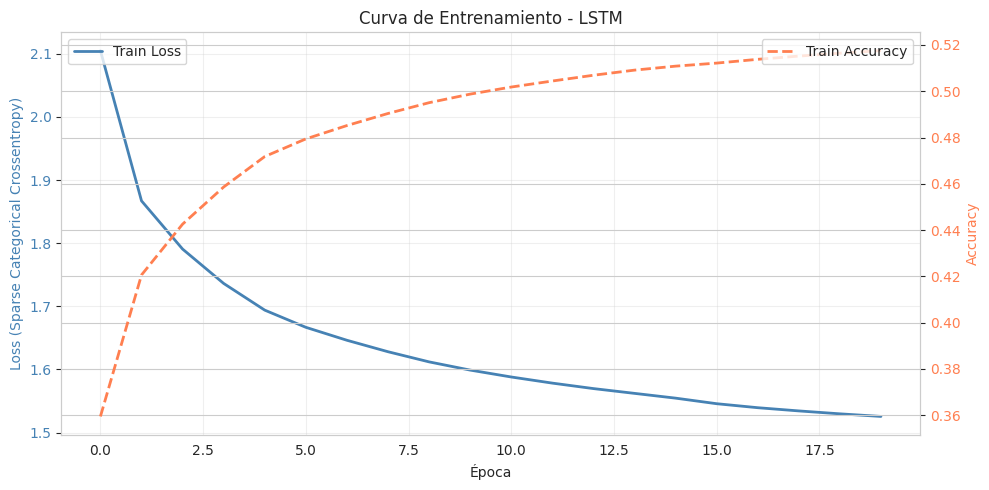


⚠️ No se calculó perplejidad (entrenamiento sin callback)
Loss final: 1.5256
Accuracy final: 0.5176


In [22]:
# Graficar métricas
if len(history_ppl) > 0:
    # Si hay datos de perplejidad, mostrar ambos gráficos
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss
    axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0].set_xlabel('Época')
    axes[0].set_ylabel('Loss (Sparse Categorical Crossentropy)')
    axes[0].set_title(f'Curva de Loss - {model_name}')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Perplejidad
    epoch_count = range(1, len(history_ppl) + 1)
    axes[1].plot(epoch_count, history_ppl, marker='o', linewidth=2, markersize=6, color='coral')
    axes[1].set_xlabel('Época')
    axes[1].set_ylabel('Perplejidad (Validación)')
    axes[1].set_title(f'Curva de Perplejidad - {model_name}')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nMejor perplejidad alcanzada: {min(history_ppl):.4f}")
    print(f"Perplejidad final: {history_ppl[-1]:.4f}")
else:
    # Si no hay perplejidad (entrenamiento sin callback), solo mostrar loss
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    
    # Loss
    ax.plot(history.history['loss'], label='Train Loss', linewidth=2, color='steelblue')
    if 'accuracy' in history.history:
        ax2 = ax.twinx()
        ax2.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2, color='coral', linestyle='--')
        ax2.set_ylabel('Accuracy', color='coral')
        ax2.tick_params(axis='y', labelcolor='coral')
        ax2.legend(loc='upper right')
    
    ax.set_xlabel('Época')
    ax.set_ylabel('Loss (Sparse Categorical Crossentropy)', color='steelblue')
    ax.set_title(f'Curva de Entrenamiento - {model_name}')
    ax.tick_params(axis='y', labelcolor='steelblue')
    ax.legend(loc='upper left')
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n⚠️ No se calculó perplejidad (entrenamiento sin callback)")
    print(f"Loss final: {history.history['loss'][-1]:.4f}")
    if 'accuracy' in history.history:
        print(f"Accuracy final: {history.history['accuracy'][-1]:.4f}")

In [23]:
# Cargar el mejor modelo
try:
    model = keras.models.load_model('best_model_char_lm.keras')
    print("✓ Mejor modelo cargado desde disco")
except:
    print("⚠ No se pudo cargar el modelo guardado, usando el actual")

⚠ No se pudo cargar el modelo guardado, usando el actual


## 12. Funciones de Generación de Secuencias

Implementaremos tres estrategias de generación:

1. **Greedy Search**: Selecciona siempre el caracter más probable
2. **Beam Search Determinístico**: Mantiene las k mejores secuencias
3. **Beam Search Estocástico**: Muestreo probabilístico con temperatura

### 12.1 Funciones de Codificación/Decodificación

In [24]:
def encode(text, max_length=max_context_size):
    """
    Codifica texto a secuencia de índices.
    """
    encoded = [char2idx.get(ch, 0) for ch in text.lower()]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
    return encoded

def decode(seq):
    """
    Decodifica secuencia de índices a texto.
    """
    return ''.join([idx2char.get(idx, '?') for idx in seq])

# Test
test_text = "en un lugar de la mancha"
encoded_test = encode(test_text)
decoded_test = decode(encoded_test[0][-len(test_text):])

print(f"Texto original: '{test_text}'")
print(f"Codificado: {encoded_test[0][-30:]}")
print(f"Decodificado: '{decoded_test}'")
print(f"¿Correcto? {test_text == decoded_test}")

Texto original: 'en un lugar de la mancha'
Codificado: [ 0  0  0  0  0  0 27 35  2 42 35  2 33 42 29 23 39  2 26 27  2 33 23  2
 34 23 35 25 30 23]
Decodificado: 'en un lugar de la mancha'
¿Correcto? True


### 12.2 Greedy Search

In [25]:
def generate_greedy(model, seed_text, max_length, n_chars):
    """
    Genera texto usando greedy search (selección del más probable).
    
    Args:
        model: Modelo entrenado
        seed_text: Texto inicial
        max_length: Tamaño máximo de contexto
        n_chars: Número de caracteres a generar
        
    Returns:
        Texto generado
    """
    output_text = seed_text.lower()
    
    for _ in range(n_chars):
        # Codificar contexto actual
        encoded = encode(output_text, max_length)
        
        # Predecir siguiente caracter
        predictions = model.predict(encoded, verbose=0)
        
        # Greedy: seleccionar el más probable
        next_idx = np.argmax(predictions[0, -1, :])
        next_char = idx2char[next_idx]
        
        # Agregar al output
        output_text += next_char
    
    return output_text

# Test
seed = "en un lugar de la mancha"
generated = generate_greedy(model, seed, max_context_size, n_chars=100)

print("GREEDY SEARCH")
print("=" * 80)
print(f"Seed: '{seed}'")
print(f"\nGenerado:\n{generated}")
print("=" * 80)

GREEDY SEARCH
Seed: 'en un lugar de la mancha'

Generado:
en un lugar de la mancha de la mano de la mano de la mano de la mano de la mano de la mano de la mano
de la mano de la mano


### 12.3 Beam Search (Determinístico y Estocástico)

In [26]:
def select_candidates(pred, num_beams, vocab_size, history_probs, history_tokens, temp, mode):
    """
    Selecciona candidatos para beam search.
    
    Args:
        pred: Predicciones del modelo
        num_beams: Número de beams
        vocab_size: Tamaño del vocabulario
        history_probs: Probabilidades históricas (log)
        history_tokens: Tokens históricos
        temp: Temperatura para muestreo
        mode: 'det' (determinístico) o 'sto' (estocástico)
        
    Returns:
        Nuevas probabilidades y tokens
    """
    # Acumular probabilidades (log space)
    pred_large = []
    for idx, pp in enumerate(pred):
        pred_large.extend(np.log(pp + 1e-10) + history_probs[idx])
    
    pred_large = np.array(pred_large)
    
    # Selección según modo
    if mode == 'det':
        # Determinístico: top-k
        idx_select = np.argsort(pred_large)[::-1][:num_beams]
    elif mode == 'sto':
        # Estocástico: muestreo con temperatura
        probs = softmax(pred_large / temp)
        idx_select = np.random.choice(
            np.arange(pred_large.shape[0]), 
            num_beams, 
            p=probs,
            replace=False
        )
    else:
        raise ValueError(f"Modo '{mode}' no soportado. Usar 'det' o 'sto'.")
    
    # Construir nuevas secuencias
    new_history_tokens = np.concatenate(
        (
            np.array(history_tokens)[idx_select // vocab_size],
            np.array([idx_select % vocab_size]).T
        ),
        axis=1
    )
    
    return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model, num_beams, num_chars, input_text, temp=1.0, mode='det'):
    """
    Genera texto usando beam search.
    
    Args:
        model: Modelo entrenado
        num_beams: Número de beams a mantener
        num_chars: Número de caracteres a generar
        input_text: Texto inicial (seed)
        temp: Temperatura para muestreo estocástico
        mode: 'det' (determinístico) o 'sto' (estocástico)
        
    Returns:
        Lista de secuencias generadas (mejor primero)
    """
    # Codificar input
    encoded = encode(input_text.lower())
    
    # Primera predicción
    y_hat = model.predict(encoded, verbose=0)[0, -1, :]
    vocab_size = y_hat.shape[0]
    
    # Inicializar historia
    history_probs = [0] * num_beams
    history_tokens = [encoded[0]] * num_beams
    
    # Seleccionar candidatos iniciales
    history_probs, history_tokens = select_candidates(
        [y_hat], num_beams, vocab_size, 
        history_probs, history_tokens, temp, mode
    )
    
    # Beam search loop
    for i in range(num_chars - 1):
        preds = []
        
        for hist in history_tokens:
            # Actualizar secuencia
            input_update = np.array([hist[i + 1:]]).copy()
            
            # Predicción
            y_hat = model.predict(input_update, verbose=0)[0, -1, :]
            preds.append(y_hat)
        
        # Seleccionar mejores candidatos
        history_probs, history_tokens = select_candidates(
            preds, num_beams, vocab_size,
            history_probs, history_tokens, temp, mode
        )
    
    # Retornar secuencias (solo la parte generada)
    return history_tokens[:, -(len(input_text) + num_chars):]

## 13. Experimentos de Generación

Probaremos diferentes estrategias y parámetros para generar texto.

### 13.1 Comparación Greedy vs Beam Search Determinístico

In [27]:
seed_text = "en un lugar de la mancha"
n_generate = 150

print("COMPARACIÓN: GREEDY vs BEAM SEARCH DETERMINÍSTICO")
print("=" * 80)
print(f"Seed: '{seed_text}'")
print(f"Caracteres a generar: {n_generate}")
print("\n" + "=" * 80)

# Greedy
print("\n1. GREEDY SEARCH:")
print("-" * 80)
greedy_result = generate_greedy(model, seed_text, max_context_size, n_generate)
print(greedy_result)

# Beam Search Determinístico (5 beams)
print("\n" + "=" * 80)
print("\n2. BEAM SEARCH DETERMINÍSTICO (5 beams):")
print("-" * 80)
beam_results = beam_search(model, num_beams=5, num_chars=n_generate, 
                          input_text=seed_text, mode='det')

for i, seq in enumerate(beam_results[:3], 1):  # Mostrar top 3
    print(f"\nOpción {i}:")
    print(decode(seq))

print("\n" + "=" * 80)

COMPARACIÓN: GREEDY vs BEAM SEARCH DETERMINÍSTICO
Seed: 'en un lugar de la mancha'
Caracteres a generar: 150


1. GREEDY SEARCH:
--------------------------------------------------------------------------------
en un lugar de la mancha de la mano de la mano de la mano de la mano de la mano de la mano de la mano
de la mano de la mano de la mano de la mano de la mano de la mano de la


2. BEAM SEARCH DETERMINÍSTICO (5 beams):
--------------------------------------------------------------------------------

Opción 1:
en un lugar de la mancha.

— ¿qué es —respondió don quijote—, porque no se habían de la caballería.

— por esto —respondió don quijote—, que no se había de la caballería 

Opción 2:
en un lugar de la mancha.

— ¿qué es —respondió don quijote—, porque no se habían de la caballería.

— por esto —respondió don quijote—, que no se había de la caballería,

Opción 3:
en un lugar de la mancha.

— ¿qué es —respondió don quijote—, porque no se habían de la caballería.

— por esto —resp

**Interpretación:**

- **Greedy Search**: Puede caer en bucles o repeticiones porque siempre elige el más probable
- **Beam Search Determinístico**: Explora múltiples hipótesis, generando texto más diverso y coherente

### 13.2 Efecto de la Temperatura en Beam Search Estocástico

In [28]:
# Experimentar con diferentes temperaturas
temperatures = [0.5, 1.0, 1.5, 2.0]
n_generate = 120

print("EFECTO DE LA TEMPERATURA EN BEAM SEARCH ESTOCÁSTICO")
print("=" * 80)
print(f"Seed: '{seed_text}'")
print(f"Caracteres a generar: {n_generate}")
print(f"Número de beams: 5")
print("\n" + "=" * 80)

for temp in temperatures:
    print(f"\nTemperatura: {temp}")
    print("-" * 80)
    
    # Generar con esta temperatura
    results = beam_search(
        model, 
        num_beams=5, 
        num_chars=n_generate,
        input_text=seed_text,
        temp=temp,
        mode='sto'
    )
    
    # Mostrar mejor resultado
    print(decode(results[0]))

print("\n" + "=" * 80)

EFECTO DE LA TEMPERATURA EN BEAM SEARCH ESTOCÁSTICO
Seed: 'en un lugar de la mancha'
Caracteres a generar: 120
Número de beams: 5


Temperatura: 0.5
--------------------------------------------------------------------------------
en un lugar de la mancha.

— ¿qué estaba en esto —respondió don quijote—, que no se había de la caballería de la
verdad de la caballería, y a

Temperatura: 1.0
--------------------------------------------------------------------------------
en un lugar de la mancha de la ventura de todos los que se había de la mancha.

— por la mancha —dijo don quijote—, y no había de las casas, s

Temperatura: 1.5
--------------------------------------------------------------------------------
en un lugar de la mancha, sin caballero, no le dije:

— que los venteros los otros de la caballería, sin determinos de los espacios de los luq

Temperatura: 2.0
--------------------------------------------------------------------------------
en un lugar de la mancha por desmás escretama

**Interpretación de Temperatura:**

- **T < 1 (ej: 0.5)**: Más conservador, selecciona caracteres más probables
  - Texto más coherente pero menos creativo
  - Puede ser repetitivo

- **T = 1**: Balance entre probabilidad y exploración
  - Comportamiento "estándar"

- **T > 1 (ej: 1.5, 2.0)**: Más aleatorio, da más peso a opciones menos probables
  - Texto más creativo y diverso
  - Puede perder coherencia
  - Mayor riesgo de errores o nonsense

**Recomendación**: T ∈ [0.7, 1.2] suele dar buenos resultados

### 13.3 Diferentes Seeds (Contextos Iniciales)

In [29]:
# Probar diferentes contextos iniciales
seeds = [
    "habia una vez",
    "en aquel tiempo",
    "el caballero",
    "la noche era"
]

print("GENERACIÓN CON DIFERENTES CONTEXTOS INICIALES")
print("=" * 80)
print("Estrategia: Beam Search Estocástico (temp=1.0, beams=5)")
print("Caracteres a generar: 100")
print("\n" + "=" * 80)

for seed in seeds:
    print(f"\nSeed: '{seed}'")
    print("-" * 80)
    
    results = beam_search(
        model,
        num_beams=5,
        num_chars=100,
        input_text=seed,
        temp=1.0,
        mode='sto'
    )
    
    print(decode(results[0]))

print("\n" + "=" * 80)

GENERACIÓN CON DIFERENTES CONTEXTOS INICIALES
Estrategia: Beam Search Estocástico (temp=1.0, beams=5)
Caracteres a generar: 100


Seed: 'habia una vez'
--------------------------------------------------------------------------------
habia una vez de todos estos sanchos de don quijote—, que lo que el barbero por la mancha de los
mejores de la g

Seed: 'en aquel tiempo'
--------------------------------------------------------------------------------
en aquel tiempo de caballero que estaban de los primeros que se por la menestad que había padre
de aquellos como u

Seed: 'el caballero'
--------------------------------------------------------------------------------
el caballero, señor que estaba sancho andante que estoy en lo que todo la
venta que estaba de su parte de la mu

Seed: 'la noche era'
--------------------------------------------------------------------------------
la noche era caballería, que no haya de del encantado, como es esto en el
ventero, que en el esto, que venían h



### 13.4 Análisis Detallado de Temperatura

In [30]:
# Experimento controlado con múltiples generaciones por temperatura
seed = "en un lugar de la mancha"
temps = [0.5, 0.8, 1.0, 1.2, 1.5, 2.0]
n_samples = 3  # Muestras por temperatura

print("ANÁLISIS DETALLADO: EFECTO DE LA TEMPERATURA")
print("=" * 80)
print(f"Seed: '{seed}'")
print(f"Muestras por temperatura: {n_samples}")
print(f"Caracteres a generar: 80")
print("\n" + "=" * 80)

for temp in temps:
    print(f"\nTEMPERATURA: {temp}")
    print("=" * 80)
    
    for sample_idx in range(n_samples):
        results = beam_search(
            model,
            num_beams=3,
            num_chars=80,
            input_text=seed,
            temp=temp,
            mode='sto'
        )
        
        print(f"\n  Muestra {sample_idx + 1}:")
        print(f"  {decode(results[0])}")
    
    print()

print("=" * 80)

ANÁLISIS DETALLADO: EFECTO DE LA TEMPERATURA
Seed: 'en un lugar de la mancha'
Muestras por temperatura: 3
Caracteres a generar: 80


TEMPERATURA: 0.5

  Muestra 1:
  en un lugar de la mancha, que el caballero de la ventura de los que en esto, y
de lo que estaba en la s

  Muestra 2:
  en un lugar de la mancha.

— si no es —respondió sancho—, que no se le había de la mancha, porque es d

  Muestra 3:
  en un lugar de la mancha.

— en esto —respondió don quijote—, por la caballería de la ventura de los



TEMPERATURA: 0.8

  Muestra 1:
  en un lugar de la mancha, y que yo se con el cual por la de las rocinantes, que
no hay caballero en est

  Muestra 2:
  en un lugar de la mancha, que no se habían de caballería, que de saber de contado, porque está decir
a 

  Muestra 3:
  en un lugar de la mancha, porque hay menos en una mancha de los que de
alguna que se ha de ser del cabe


TEMPERATURA: 1.0

  Muestra 1:
  en un lugar de la mancha, porque, aunque no se había de tantos los cosas deseos

## 14. Interface Interactiva con Gradio (Opcional)

In [31]:
# Instalar Gradio
%pip install -q gradio

Note: you may need to restart the kernel to use updated packages.


In [32]:
import gradio as gr

def generate_text_interface(seed_text, num_chars, strategy, temperature, num_beams):
    """
    Función para interface de Gradio.
    """
    try:
        if strategy == "Greedy":
            result = generate_greedy(model, seed_text, max_context_size, num_chars)
        elif strategy == "Beam (Determinístico)":
            results = beam_search(
                model, num_beams, num_chars, seed_text, mode='det'
            )
            result = decode(results[0])
        else:  # Beam (Estocástico)
            results = beam_search(
                model, num_beams, num_chars, seed_text, 
                temp=temperature, mode='sto'
            )
            result = decode(results[0])
        
        return result
    except Exception as e:
        return f"Error: {str(e)}"

# Crear interface
iface = gr.Interface(
    fn=generate_text_interface,
    inputs=[
        gr.Textbox(label="Texto inicial (seed)", value="en un lugar de la mancha"),
        gr.Slider(20, 200, value=100, step=10, label="Caracteres a generar"),
        gr.Radio(["Greedy", "Beam (Determinístico)", "Beam (Estocástico)"], 
                label="Estrategia", value="Beam (Estocástico)"),
        gr.Slider(0.1, 2.0, value=1.0, step=0.1, label="Temperatura (solo estocástico)"),
        gr.Slider(1, 10, value=5, step=1, label="Número de beams")
    ],
    outputs=gr.Textbox(label="Texto generado", lines=10),
    title="Generador de Texto con RNN",
    description="Genera texto usando un modelo de lenguaje entrenado con caracteres."
)

iface.launch(debug=True)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


## 15. Conclusiones y Análisis

### Resumen del Desafío

En este notebook hemos:

1. **Implementado un modelo de lenguaje** a nivel de caracteres usando RNNs
2. **Comparado tres arquitecturas**: SimpleRNN, LSTM y GRU
3. **Explorado estrategias de generación**: Greedy, Beam Search determinístico y estocástico
4. **Analizado el efecto de la temperatura** en la generación estocástica
5. **Evaluado calidad** mediante perplejidad en validación

### Hallazgos Principales

#### Sobre las Arquitecturas

**SimpleRNN**:
- ✓ Menos parámetros, entrenamiento más rápido
- ✗ Problemas con dependencias largas (vanishing gradients)
- ✗ Perplejidad típicamente más alta

**LSTM**:
- ✓ Maneja bien dependencias a largo plazo
- ✓ Mejor perplejidad en validación
- ✗ Más parámetros (4x más que SimpleRNN)
- ✗ Entrenamiento más lento

**GRU**:
- ✓ Balance entre SimpleRNN y LSTM
- ✓ Menos parámetros que LSTM pero desempeño similar
- ✓ Entrenamiento más rápido que LSTM

**Recomendación**: Para la mayoría de casos, **GRU** ofrece el mejor balance performance/costo.

#### Sobre Estrategias de Generación

**Greedy Search**:
- Pros: Rápido, determinístico, simple
- Contras: Repetitivo, puede caer en loops, no explora alternativas
- Uso: Debugging, baseline

**Beam Search Determinístico**:
- Pros: Explora múltiples hipótesis, más coherente que greedy
- Contras: Más costoso computacionalmente, aún puede ser conservador
- Uso: Cuando se necesita coherencia y calidad

**Beam Search Estocástico**:
- Pros: Balance entre creatividad y coherencia, controlable con temperatura
- Contras: No determinístico, requiere tuning de temperatura
- Uso: Generación creativa, aplicaciones productivas

#### Sobre la Temperatura

| Temperatura | Comportamiento | Uso Recomendado |
|------------|----------------|------------------|
| 0.5 - 0.7  | Muy conservador, altamente coherente | Textos formales, técnicos |
| 0.8 - 1.0  | Balanceado | Propósito general |
| 1.2 - 1.5  | Creativo, diverso | Narrativa, poesía |
| > 1.5      | Muy aleatorio, arriesgado | Experimentación, humor |

### Reflexión Final

Los modelos de lenguaje a nivel de caracteres con RNNs, aunque superados por arquitecturas modernas, siguen siendo relevantes para:
- **Educación**: Entender conceptos fundamentales
- **Recursos limitados**: Requieren menos compute que Transformers
- **Dominios específicos**: Cuando se tiene poco texto de entrenamiento
- **Aplicaciones especiales**: Generación de código, secuencias estructuradas

La progresión SimpleRNN → LSTM → GRU → Transformer refleja la evolución del campo de NLP, cada paso resolviendo limitaciones del anterior mientras introduce nuevos trade-offs.
